## Problem 1 (20 points): Complete Exercise 2: Sentiment Analysis on Movie Reviews from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

* Assuming that you have downloaded the scikit-learn source code (depending on your distribution). You may need to download this directly from Gitub at https://github.com/scikit-learn/scikit-learn:
    * The data can be downloaded using https://github.com/scikit-learn/scikit-learn/blob/master/doc/tutorial/text_analytics/data/movie_reviews/fetch_data.py.
    * A skeleton for the solution can be found in https://github.com/scikit-learn/scikit-learn/blob/master/doc/tutorial/text_analytics/skeletons/exercise_02_sentiment.py.
    * A completed solution can be found in https://github.com/scikit-learn/scikit-learn/blob/master/doc/tutorial/text_analytics/solutions/exercise_02_sentiment.py.
* **It is ok to use the solution provided in the scikit-learn distribution as a starting place for your work.**

### Modify the solution on Exercise 2 so that it can run in this iPython notebook
* This will likely involved moving around data files and/or small modifications to the script.

In [198]:
#Importing essential libraries
import nltk
import sys
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score


In [199]:
#Loading the dataset
dataset = load_files('txt_sentoken', shuffle=False)

#Printing the number of data samples
print("No of samples present in our dataset: ",len(dataset.data))


No of samples present in our dataset:  2000


In [200]:
#Creating a DataFrame out of the dataset.data
data=pd.DataFrame([dataset.data,dataset.target]).T

data.columns=['review','sentiment']
data.head(5)

,review,sentiment
0,b'plot : two teen couples go to a church party...,0
1,b'the happy bastard\'s quick movie review \nda...,0
2,"b""it is movies like these that make a jaded mo...",0
3,"b' "" quest for camelot "" is warner bros . \' f...",0
4,b'synopsis : a mentally unstable man undergoin...,0


We can see that our review needs a lot of pre-processing

Preprocessing the "review" column and making it ready for analysis.

Step 1: At first the the "review" is traversed and only the alphabets are kept while filtering out everything else and then the alphabets are converted into lowercase.

Step 2: The most common words also known as stop words are removed.

Step 3: Lemmatization is performed.

Step 4: Stemming is performed.

In [201]:
#Displaying "review" before preprocessing begins.

print("Snapshot of data['review']\n\n")
data['review']

Snapshot of data['review']




0       b'plot : two teen couples go to a church party...
1       b'the happy bastard\'s quick movie review \nda...
2       b"it is movies like these that make a jaded mo...
3       b' " quest for camelot " is warner bros . \' f...
4       b'synopsis : a mentally unstable man undergoin...
                              ...                        
1995    b"wow ! what a movie . \nit's everything a mov...
1996    b'richard gere can be a commanding actor , but...
1997    b'glory--starring matthew broderick , denzel w...
1998    b'steven spielberg\'s second epic film on worl...
1999    b'truman ( " true-man " ) burbank is the perfe...
Name: review, Length: 2000, dtype: object

In [202]:
# function for text cleaning
 
def clean(text):
    text=text.decode('ISO-8859-1')
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

data['review']=data['review'].apply(lambda x: clean(x))

In [203]:
#Displaying "review" after text-cleaning.

print("Snapshot of data['review']\n\n")
data['review']

Snapshot of data['review']




0       plot two teen couples go to a church party dri...
1       the happy bastards quick movie review damn tha...
2       it is movies like these that make a jaded movi...
3       quest for camelot is warner bros first feature...
4       synopsis a mentally unstable man undergoing ps...
                              ...                        
1995    wow what a movie its everything a movie can be...
1996    richard gere can be a commanding actor but hes...
1997    glory starring matthew broderick denzel washin...
1998    steven spielbergs second epic film on world wa...
1999    truman true man burbank is the perfect name fo...
Name: review, Length: 2000, dtype: object

Graph to visualize the words and frequency in data's review.




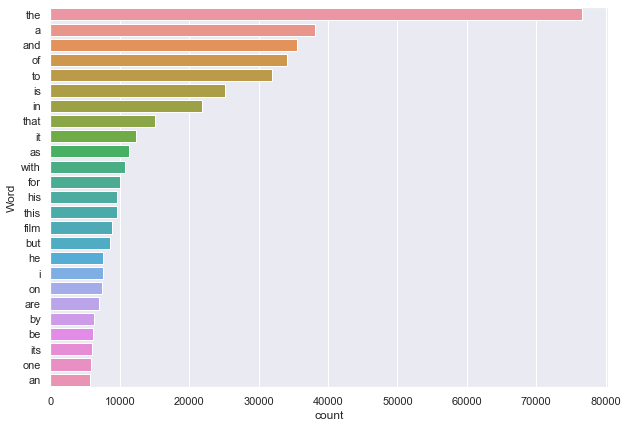

In [204]:
#Function to visualize the words and frequency in book's summary.

print("Graph to visualize the words and frequency in data's review.\n\n")

def freqwords(x, terms): 
    allwords = ' '.join([text for text in x]) 
    allwords = allwords.split() 
    fdist = nltk.FreqDist(allwords) 
    wordsdf = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 


    d = wordsdf.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(10,7))
    sns.set_theme(style="darkgrid")
    
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    #plt.title("")

    
# print 25 most frequent words 
freqwords(data['review'], 25)

In [205]:
#Removing stop words from the column "review".

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def removestopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

data['review'] = data['review'].apply(lambda x: removestopwords(x))

In [206]:
#Displaying "review" after removing stop words

print("Snapshot of data['review']\n\n")

data['review']

Snapshot of data['review']




0       plot two teen couples go church party drink dr...
1       happy bastards quick movie review damn k bug g...
2       movies like make jaded movie viewer thankful i...
3       quest camelot warner bros first feature length...
4       synopsis mentally unstable man undergoing psyc...
                              ...                        
1995    wow movie everything movie funny dramatic inte...
1996    richard gere commanding actor hes always great...
1997    glory starring matthew broderick denzel washin...
1998    steven spielbergs second epic film world war i...
1999    truman true man burbank perfect name jim carre...
Name: review, Length: 2000, dtype: object

In [207]:
#Lemmatization on 'review'
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemma=WordNetLemmatizer()

def lematizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = lemma.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


data['review'] = data['review'].apply(lambda x: lematizing(x))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sganguly/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [208]:
#Displaying "review" after Lemmmatization

print("Snapshot of data['review']\n\n")

data['review']

Snapshot of data['review']




0       plot two teen couple go church party drink dri...
1       happy bastard quick movie review damn k bug go...
2       movie like make jaded movie viewer thankful in...
3       quest camelot warner bros first feature length...
4       synopsis mentally unstable man undergoing psyc...
                              ...                        
1995    wow movie everything movie funny dramatic inte...
1996    richard gere commanding actor he always great ...
1997    glory starring matthew broderick denzel washin...
1998    steven spielberg second epic film world war ii...
1999    truman true man burbank perfect name jim carre...
Name: review, Length: 2000, dtype: object

In [209]:
#Stemming on 'review'

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


data['review'] = data['review'].apply(lambda x: stemming(x))

In [210]:
#Displaying "review" after Stemming

print("Snapshot of data['summary']\n\n")

data['review']

Snapshot of data['summary']




0       plot two teen coupl go church parti drink driv...
1       happi bastard quick movi review damn k bug got...
2       movi like make jade movi viewer thank invent t...
3       quest camelot warner bro first featur length f...
4       synopsi mental unstabl man undergo psychothera...
                              ...                        
1995    wow movi everyth movi funni dramat interest we...
1996    richard gere command actor he alway great film...
1997    glori star matthew broderick denzel washington...
1998    steven spielberg second epic film world war ii...
1999    truman true man burbank perfect name jim carre...
Name: review, Length: 2000, dtype: object

Graph to visualize the words and frequency in data's review.




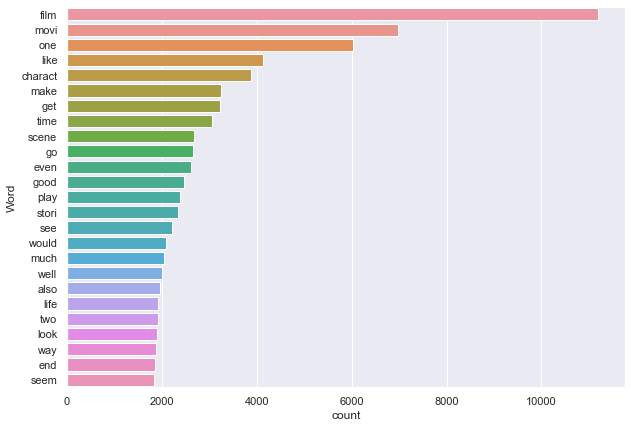

In [211]:
#Function to visualize the words and frequency in data's review.

print("Graph to visualize the words and frequency in data's review.\n\n")
# print 25 most frequent words 
freqwords(data['review'], 25)

In [212]:
#Splitting our dataset into training and testing sets
docs_train, docs_test, y_train, y_test = train_test_split(data['review'].tolist(), data['sentiment'].tolist(), test_size=0.25, random_state=51) 


In [213]:
#Creating a dataset out of our training set for data exploration
train_df = pd.DataFrame([docs_train,y_train]).T

#columns={'oldName1': 'newName1', 'oldName2': 'newName2'}
train_df.rename(columns={0: 'review', 1: 'sentiment'}, inplace=True)
#Looking into top 3 records of train_df
train_df.head(3)

,review,sentiment
0,well ill damn excel surpris confus campi far i...,1
1,gere willi poitier chase around world jackal f...,1
2,well guess time year one time year movi crafto...,0


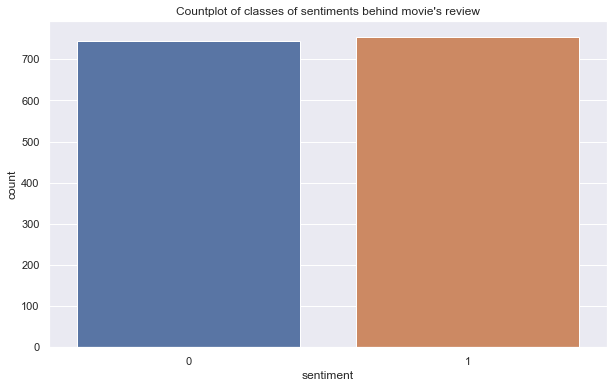

In [214]:
#Plotting the count plot of the different classes of reviews present

plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.countplot(x=train_df.sentiment)
plt.title("Countplot of classes of sentiments behind movie's review")
plt.show()

In [215]:
#Creating a new feature 'length' which is the length of each movie review
train_df['length']=train_df['review'].str.len()

In [216]:
#Peeking into the training dataset
train_df.head(10)

,review,sentiment,length
0,well ill damn excel surpris confus campi far i...,1,1872
1,gere willi poitier chase around world jackal f...,1,1940
2,well guess time year one time year movi crafto...,0,2904
3,filmcrit com colleagu norm schrager nail sessi...,1,2864
4,plot someth bunch kid go haunt hous play parod...,0,1816
5,american pie acknowledg cold hard fact movi do...,1,1805
6,note may consid portion follow text spoiler fo...,1,4359
7,high school comedi seem hot genr moment she va...,0,1889
8,stephen pleas post appropri mafia crime isnt f...,0,1338
9,sequel dont theyr suppos like toy stori far ma...,1,3278


<Figure size 720x432 with 0 Axes>

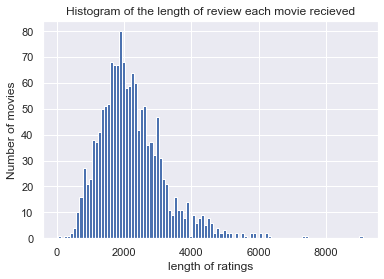

In [217]:
#Plotting the histogram of the length of the review each movie received

plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
train_df.hist(column='length',bins=100)
plt.title('Histogram of the length of review each movie recieved')
plt.xlabel('length of ratings')
plt.ylabel('Number of movies')
plt.show()

In [218]:
# Building a pipeline for the the sentiment cassification
pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, max_df=0.95)),('clf', LinearSVC(C=10000,max_iter=5000))])

In [219]:
#Defining the n_gram parameter
parameters = {'vect__ngram_range': [(1, 1), (1, 2)]}

In [ ]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-10)
grid_search.fit(docs_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(max_df=0.95, min_df=3)),
                                       ('clf',
                                        LinearSVC(C=10000, max_iter=5000))]),
             n_jobs=-10, param_grid={'vect__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'% (grid_search.cv_results_['params'][i],grid_search.cv_results_['mean_test_score'][i],grid_search.cv_results_['std_test_score'][i]))

0 params - {'vect__ngram_range': (1, 1)}; mean - 0.81; std - 0.02
1 params - {'vect__ngram_range': (1, 2)}; mean - 0.82; std - 0.02


In [ ]:
#Predicting the test values
y_predicted = grid_search.predict(docs_test)

In [ ]:
#Printing the classification report
print(metrics.classification_report(y_test, y_predicted,target_names=dataset.target_names))

              precision    recall  f1-score   support

         neg       0.92      0.86      0.89       255
         pos       0.87      0.92      0.89       245

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



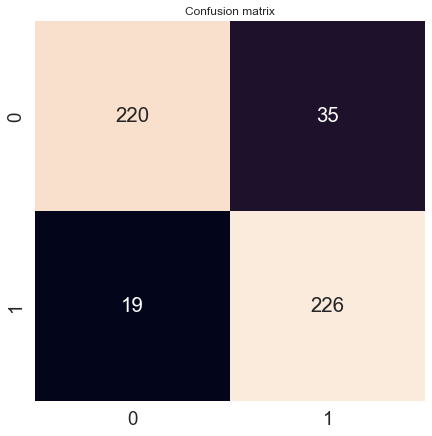

In [ ]:
#Show the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.7)
sns.heatmap(cm, annot=True, cbar=False, fmt='.0f')
sns.set(font_scale=1)
plt.title("Confusion matrix")
plt.show()

In [ ]:
#Printing the accuracy score and F1 score
print("The accuarcy score is: ",metrics.accuracy_score(y_test, y_predicted)*100,"%")
print("The F1 score is: ",metrics.f1_score(y_test, y_predicted)*100,"%")

The accuarcy score is:  89.2 %
The F1 score is:  89.32806324110672 %


## Problem 2 (20 points): Explore the Scikit-learn TfidfVectorizer Class

**Read the documentation for the TfidfVectorizer class at https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html.** 
* Define the term frequency–inverse document frequency (TF-IDF) statistic (https://en.wikipedia.org/wiki/Tf%E2%80%93idf) will likely help.
* Run the TfidfVectorizer class on the training data above (docs_train).
* Explore the min_df and max_df parameters of TfidfVectorizer. What do they mean? How do they change the features you get?
* Explore the ngram_range parameter of TfidfVectorizer. What does it mean? How does it change the features you get? (Note, large values  of ngram_range may take a long time to run!)

##### Explore the min_df and max_df parameters of TfidfVectorizer. What do they mean? How do they change the features you get?

In [226]:
#Exploring the min_df parameter of TfidfVectorizer
il=[]
al=[]
for i in range(0,20):
    pipeline = Pipeline([('vect', TfidfVectorizer(min_df=i, max_df=1000)),('clf', LinearSVC(C=10000,max_iter=5000))])

    parameters = {'vect__ngram_range': [(1, 1), (1, 2)],}
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-10)
    grid_search.fit(docs_train, y_train)

    n_candidates = len(grid_search.cv_results_['params'])
    y_predicted = grid_search.predict(docs_test)
    acc=metrics.accuracy_score(y_test, y_predicted)
    #print("For min_df: ",i," accuracy: ",acc)
    il.append(i)
    al.append(acc)
    

In [227]:
#Creating a new dataframe [min_df value || accuracy score] 
#Purpose is to plot a graph of min_df value vs accuracy score
temp = pd.DataFrame([il,al]).T
temp.columns=['min_df value','accuracy score']


temp["min_df value"] = temp["min_df value"].astype(int)
#Viewing the first 5 records of temp
temp.head(5)

,min_df value,accuracy score
0,0,0.874
1,1,0.874
2,2,0.890
3,3,0.884
4,4,0.878


Plotting a line plot of min_df value vs accuracy score


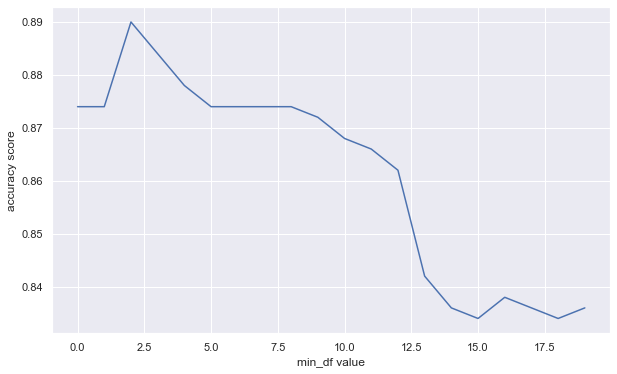

In [228]:
#Plotting a line plot of min_df value vs accuracy score
print("Plotting a line plot of min_df value vs accuracy score")
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.lineplot(data=temp, x="min_df value", y="accuracy score")
plt.show()

In [229]:
#Finding the max value of accuarcy for a given min_df value
temp[temp['accuracy score']==temp['accuracy score']. max()]

,min_df value,accuracy score
2,2,0.89


In [230]:
#Exploring the max_df parameter of TfidfVectorizer
il=[]
al=[]
for i in range(250,1000,50):
    pipeline = Pipeline([('vect', TfidfVectorizer(min_df=2, max_df=i)),('clf', LinearSVC(C=10000,max_iter=5000))])

    parameters = {'vect__ngram_range': [(1, 1), (1, 2)],}
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-20)
    grid_search.fit(docs_train, y_train)

    n_candidates = len(grid_search.cv_results_['params'])
    y_predicted = grid_search.predict(docs_test)
    
    acc=metrics.accuracy_score(y_test, y_predicted)
    #print("For max_df: ",i," accuracy: ",acc)
    il.append(i)
    al.append(acc)

In [231]:
#Creating a new dataframe [max_df value || accuracy score] 
#Purpose is to plot a graph of max_df value vs accuracy score
temp = pd.DataFrame([il,al]).T
temp.columns=['max_df value','accuracy score']

temp["max_df value"] = temp["max_df value"].astype(int)
#viewing the first 5 records of temp
temp.head(5)

,max_df value,accuracy score
0,250,0.864
1,300,0.874
2,350,0.872
3,400,0.884
4,450,0.886


Plotting a line plot of max_df value vs accuracy score


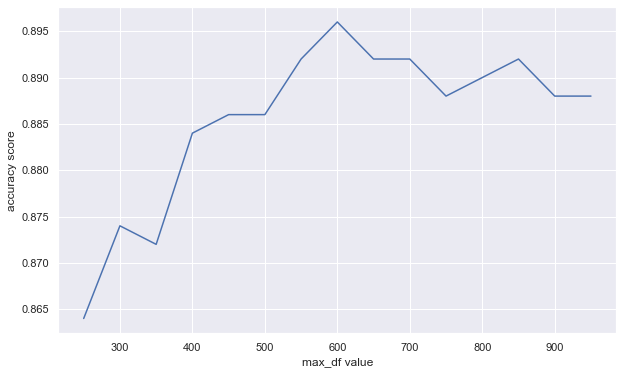

In [232]:
#Plotting a line plot of max_df value vs accuracy score
print("Plotting a line plot of max_df value vs accuracy score")
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.lineplot(data=temp, x="max_df value", y="accuracy score")
plt.show()

In [233]:
#Finding the max value of accuarcy for a given min_df value
temp[temp['accuracy score']==temp['accuracy score']. max()]

,max_df value,accuracy score
7,600,0.896


Explore the ngram_range parameter of TfidfVectorizer. What does it mean? How does it change the features you get? (Note, large values of ngram_range may take a long time to run!)

In [234]:
#Exploring the n_gram parameter

pipeline = Pipeline([('vect', TfidfVectorizer(min_df=2, max_df=600)),('clf', LinearSVC(C=10000,max_iter=5000))])

parameters = {'vect__ngram_range': [(1, 1),(1, 2),(1, 3),(1, 4),(1, 5)]}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-10)
grid_search.fit(docs_train, y_train)

il=[]
al=[]
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    al.append(grid_search.cv_results_['mean_test_score'][i])
    il.append(grid_search.cv_results_['params'][i])
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'% (grid_search.cv_results_['params'][i],grid_search.cv_results_['mean_test_score'][i],grid_search.cv_results_['std_test_score'][i]))

y_predicted = grid_search.predict(docs_test)

print("\n\nThe best accuracy score by n-gram param is: ",metrics.accuracy_score(y_test, y_predicted)*100,"%")

0 params - {'vect__ngram_range': (1, 1)}; mean - 0.80; std - 0.02
1 params - {'vect__ngram_range': (1, 2)}; mean - 0.82; std - 0.02
2 params - {'vect__ngram_range': (1, 3)}; mean - 0.82; std - 0.02
3 params - {'vect__ngram_range': (1, 4)}; mean - 0.82; std - 0.02
4 params - {'vect__ngram_range': (1, 5)}; mean - 0.82; std - 0.02


The best accuracy score by n-gram param is:  89.60000000000001 %


In [235]:
#Creating a new dataframe [n_gram || accuracy score] 

temp = pd.DataFrame([il,al]).T
temp.columns=['n_gram',' mean accuracy score']


#viewing the first 5 records of temp
temp.head(5)

,n_gram,mean accuracy score
0,"{'vect__ngram_range': (1, 1)}",0.798
1,"{'vect__ngram_range': (1, 2)}",0.819333
2,"{'vect__ngram_range': (1, 3)}",0.821333
3,"{'vect__ngram_range': (1, 4)}",0.820667
4,"{'vect__ngram_range': (1, 5)}",0.821333


## Problem 3 (20 points): Machine Learning Algorithms

* "fit" your TfidfVectorizer using docs_train
    * Compute "Xtrain", a Tf-idf-weighted document-term matrix using the transform function on docs_train
    * Compute "Xtest", a Tf-idf-weighted document-term matrix using the transform function on docs_test
    * Note, be sure to use the same Tf-idf-weighted class (**"fit" using docs_train**) to transform **both** docs_test and docs_train

In [236]:
#Performing tf-idf 

tfidf_vectorizer = TfidfVectorizer(min_df=2,max_df=600, ngram_range=(1,3))

Xtrain = tfidf_vectorizer.fit_transform(docs_train)

Xtest = tfidf_vectorizer.transform(docs_test)

* Examine two classifiers provided by scikit-learn 
    * LinearSVC
    * KNeighborsClassifier
    * Try a number of different parameter settings for each and judge your performance using a confusion matrix (see Problem 1 for an example).
* Does one classifier, or one set of parameters work better?
    * Why do you think it might be working better?

In [237]:

il=[]
al=[]

for i in range(5,100):
    svc = LinearSVC(C=i,max_iter=10000).fit(Xtrain,y_train)

    svpred=svc.predict(Xtest)

    al.append(accuracy_score(y_test,svpred))
    il.append(i)




In [238]:
#Creating a new dataframe [k value || accuracy score] 
#Purpose is to plot a graph of k value vs accuracy score
temp = pd.DataFrame([il,al]).T
temp.columns=['C value','accuracy score']

temp["C value"] = temp["C value"].astype(int)
#viewing the first 5 records of temp
temp.head(5)

,C value,accuracy score
0,5,0.896
1,6,0.896
2,7,0.896
3,8,0.896
4,9,0.898


Plotting a line plot of C value vs accuracy score


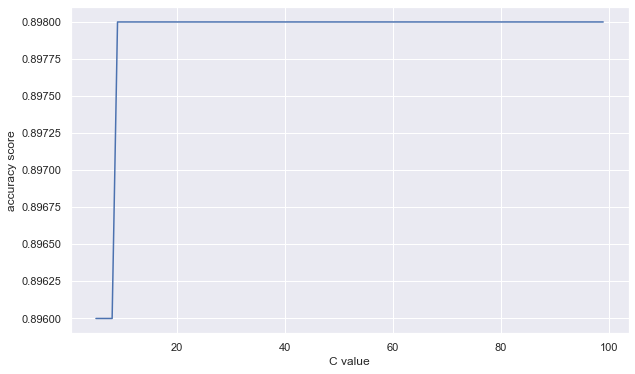

In [239]:
#Plotting a line plot of max_df value vs accuracy score
print("Plotting a line plot of C value vs accuracy score")
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.lineplot(data=temp, x="C value", y="accuracy score")
plt.show()

In [240]:
#Finding the max value of accuacy for a given C value
temp[temp['accuracy score']==temp['accuracy score']. max()]

,C value,accuracy score
4,9,0.898
5,10,0.898
6,11,0.898
7,12,0.898
8,13,0.898
...,...,...
90,95,0.898
91,96,0.898
92,97,0.898
93,98,0.898


The accuarcy score is:  89.8 %
The F1 score is:  89.72332015810277 %





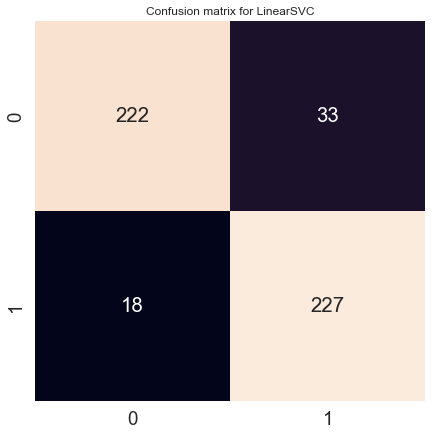

In [241]:
svc = LinearSVC(C=9,max_iter=10000).fit(Xtrain,y_train)

svpred=svc.predict(Xtest)

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  

#Printing the accuracy score and F1 score
print("The accuarcy score is: ",accuracy_score(y_test,svpred)*100,"%")
print("The F1 score is: ",metrics.f1_score(y_test, y_predicted)*100,"%")

print("\n\n")
#Show the confusion matrix
cm = metrics.confusion_matrix(y_test,svpred)
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.7)
sns.heatmap(cm, annot=True, cbar=False, fmt='.0f')
sns.set(font_scale=1)
plt.title("Confusion matrix for LinearSVC")
plt.show()

In [242]:
#Finding wrong predictions

indices_svc = [i for i in range(len(y_test)) if y_test[i] != svpred[i]]

#temp=pd.DataFrame(docs_test.tolist())
wrong_predictions = data.iloc[indices_svc,:]

wrong_predictions.head(5)

,review,sentiment
7,that exactli long movi felt werent even nine l...,0
15,john carpent make b movi alway halloween escap...,0
36,among multitud erot thriller releas earli woma...,0
40,lengthi lousi two word describ bore drama engl...,0
42,pseudo intellectu film pseudo intellectu world...,0


In [243]:
il=[]
al=[]
for i in range(100,1100,25):
    k = KNeighborsClassifier(weights='distance',n_neighbors=i).fit(Xtrain,y_train)

    k_pred=k.predict(Xtest)

    al.append(accuracy_score(y_test,k_pred))
    il.append(i)




In [244]:
#Creating a new dataframe [k value || accuracy score] 
#Purpose is to plot a graph of k value vs accuracy score
temp = pd.DataFrame([il,al]).T
temp.columns=['k value','accuracy score']

temp["k value"] = temp["k value"].astype(int)
#viewing the first 5 records of temp
temp.head(5)

,k value,accuracy score
0,100,0.784
1,125,0.792
2,150,0.796
3,175,0.786
4,200,0.808


Plotting a line plot of k value vs accuracy score


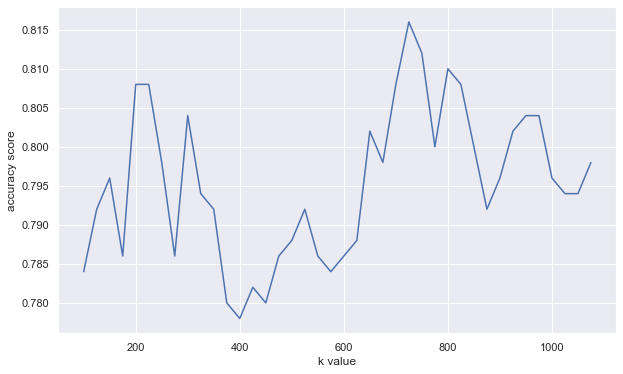

In [245]:
#Plotting a line plot of k value vs accuracy score
print("Plotting a line plot of k value vs accuracy score")
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
sns.lineplot(data=temp, x="k value", y="accuracy score")
plt.show()

In [246]:
#Finding the max value of accuarcy for a given k value
temp[temp['accuracy score']==temp['accuracy score']. max()]

,k value,accuracy score
25,725,0.816


The accuarcy score is:  81.6 %
The F1 score is:  81.52610441767068 %





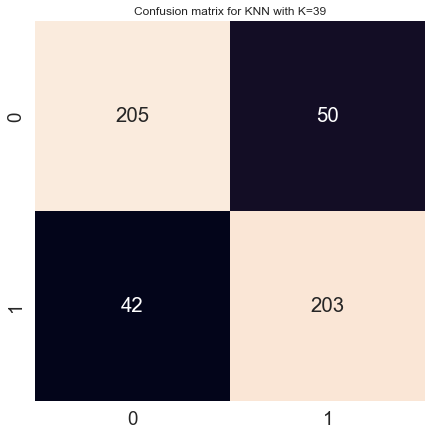

In [247]:
k = KNeighborsClassifier(weights='distance',n_neighbors=725).fit(Xtrain,y_train)

k_pred=k.predict(Xtest)

from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
  


#Printing the accuracy score and F1 score
print("The accuarcy score is: ",accuracy_score(y_test,k_pred)*100,"%")
print("The F1 score is: ",metrics.f1_score(y_test, k_pred)*100,"%")

print("\n\n")
#Show the confusion matrix
cm = metrics.confusion_matrix(y_test,k_pred)
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.7)
sns.heatmap(cm, annot=True, cbar=False, fmt='.0f')
sns.set(font_scale=1)
plt.title("Confusion matrix for KNN with K=39")
plt.show()

In [248]:
#Finding wrong predictions

indices_k = [i for i in range(len(y_test)) if y_test[i] != k_pred[i]]

#temp=pd.DataFrame(docs_test.tolist())
wrong_predictions = data.iloc[indices_k,:]

wrong_predictions.head(5)

,review,sentiment
7,that exactli long movi felt werent even nine l...,0
12,high fli hong kong style filmmak made way clas...,0
15,john carpent make b movi alway halloween escap...,0
28,follow disney live action dalmatian that bette...,0
34,your watch near two hour bore foul mouth flori...,0




* For a particular choice of parameters and classifier, look at 2 examples where the prediction was incorrect.
    * Can you conjecture on why the classifier made a mistake for this prediction?

In [249]:
#Finding records where both classifiers failed to make prediction
def intersection(indices_svc, indices_k):
    intersection = [value for value in indices_svc if value in indices_k]
    return intersection

print("No of wrong predictions by SVC: ",len(indices_svc))

print("No of wrong predictions by KNN: ",len(indices_k))

print("No of wrong predictions by both: ",len(intersection(indices_svc, indices_k)))


No of wrong predictions by SVC:  51
No of wrong predictions by KNN:  92
No of wrong predictions by both:  36


In [250]:
#We can see that for all of these records where sentiment = 0 the predictions failed.
data.iloc[intersection(indices_svc, indices_k),:].head()

,review,sentiment
7,that exactli long movi felt werent even nine l...,0
15,john carpent make b movi alway halloween escap...,0
36,among multitud erot thriller releas earli woma...,0
40,lengthi lousi two word describ bore drama engl...,0
47,instinct kind movi inexperienc moviego undoubt...,0


## Problem 4 (20 points): Open Ended Question:  Finding the Right Plot

* Can you find a two-dimensional plot in which the positive and negative reviews are separated?
    * This problem is hard since you will likely have thousands of features for review, and you will need to transform these thousands of features into just two numbers (so that you can make a 2D plot).
* Note, I was not able to find such a plot myself!
    * So, this problem is about **trying** but perhaps **not necessarily succeeding**!
* I tried two things, neither of which worked very well.
    * I first plotted the length of the review versus the number of features we compute that are in that review
    * Second I used Principle Component Analysis on a subset of the features.
* Can you do better than I did!?

Plotting the length of the review versus the number of features in that review

In [251]:
#Creating a dataframe of features and length of review
vectorizer = TfidfVectorizer(min_df=2, max_df=600, ngram_range=(1,3))

vectorized_matrix = vectorizer.fit_transform(train_df.review)

vec_df = pd.DataFrame(data=vectorized_matrix.todense(),columns=vectorizer.get_feature_names())


def get_num_features(idx: int) -> int:
    return len(np.nonzero(vec_df.iloc[idx].values)[0])

num_tokens = []
for idx, _ in train_df.iterrows():
    num_tokens.append(get_num_features(idx))

train_df['num_features'] = num_tokens

train_df.head(5)

,review,sentiment,length,num_features
0,well ill damn excel surpris confus campi far i...,1,1872,330
1,gere willi poitier chase around world jackal f...,1,1940,336
2,well guess time year one time year movi crafto...,0,2904,512
3,filmcrit com colleagu norm schrager nail sessi...,1,2864,477
4,plot someth bunch kid go haunt hous play parod...,0,1816,344


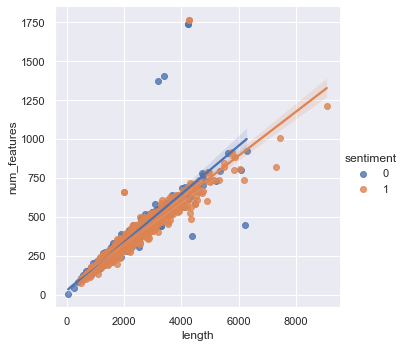

In [253]:
sns.lmplot(x='length', y='num_features', data=train_df, hue='sentiment')
plt.show()